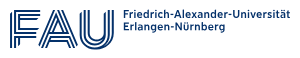

# Assignment 1: Interpretability

In this assignment, we wil work on the model interpretability. First, we will implement LIME (Local interpretable model-agnostic explanations) and then explore SHAP (SHapley Additive exPlanations). Information about SHAP can be found [here](https://arxiv.org/abs/1705.07874).

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement and Test LIME


The aim of this assignment is to implement LIME using the information from the lecture and the publication. You should rely on the Inception V3 neural network. In addition, the focus would be on analysing the top 1 and top 2 predictions. The focus are images for this assignment. Superpixels are allowed to be used for making the task easier.
Note that you should not use an available LIME python-based library.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

In [1]:
!pip install scikit-image

In [17]:
import torch
import torchvision
import numpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
import json
import requests
from skimage.segmentation import quickshift
from skimage.color import gray2rgb
import numpy as np
from skimage.segmentation import mark_boundaries
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression


## Load the Inception V3 Model

In [2]:
# Load the pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)
model.eval()  # Set to evaluation mode

/home/user/AdvancedTopicsInDeepLearning/Assignment1-Interpretability/ATDL/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/AdvancedTopicsInDeepLearning/Assignment1-Interpretability/ATDL/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

## Preprocessing the input image to be as predicted by the Inception V3 Model

In [3]:
# ImageNet normalization & resize for InceptionV3
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# Load ImageNet class index to labels
LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
labels = requests.get(LABELS_URL).text.strip().split("\n")

## A Helper Function to process and predict the input image

In [5]:
def predict_image(img_path):
    # Load image
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Preprocess
    input_tensor = preprocess(img).unsqueeze(0)

    # Inference
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)

    # Top-5 Predictions
    top5 = torch.topk(probs, 5)
    for i, idx in enumerate(top5.indices):
        print(f"{i+1}: {labels[idx]} — {top5.values[i].item()*100:.2f}%")

    return img, input_tensor, top5.indices[0].item()  # return top-1 class too

## Prediction for the 3 input images:


Predicting for: input_Three.JPG


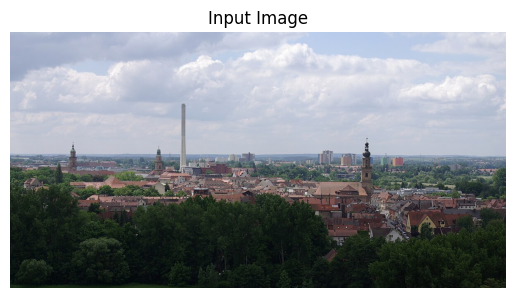

1: seashore — 8.20%
2: obelisk — 6.31%
3: mosque — 5.47%
4: airliner — 5.27%
5: lakeside — 4.47%

Predicting for: input_Two.jpg


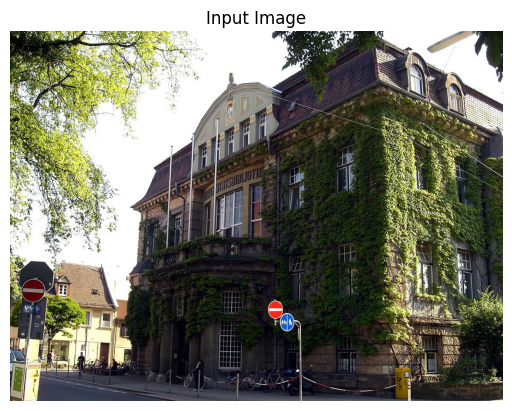

1: palace — 20.90%
2: castle — 15.58%
3: streetcar — 11.82%
4: cab — 2.79%
5: gondola — 2.58%

Predicting for: input_One.JPG


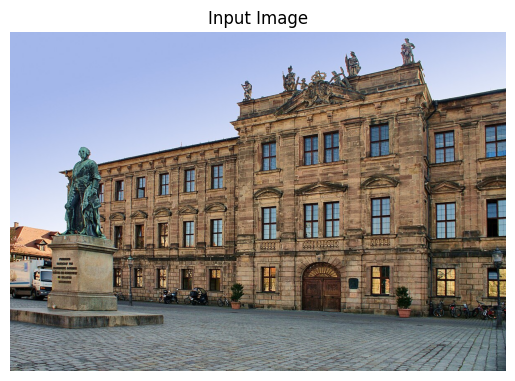

1: palace — 36.35%
2: castle — 18.29%
3: gondola — 2.16%
4: bell cote — 1.19%
5: fountain — 1.05%


In [6]:
paths = [
    'input_Three.JPG',
    'input_Two.jpg',
    'input_One.JPG'
]

for path in paths:
    print(f"\nPredicting for: {path}")
    img, tensor, top_class = predict_image(path)

## Superpixel Segmentation Function

In [7]:
def segment_superpixels(image, ratio=0.5, kernel_size=15, max_dist=6):
    """
    Segments an image into superpixels using quickshift.

    Args:
        image: PIL image
        ratio, kernel_size, max_dist: tuning parameters for quickshift

    Returns:
        segments: 2D array where each pixel has a superpixel label
    """
    # Convert to NumPy array (if not already)
    img_np = np.array(image)

    # Ensure image is in RGB format
    if len(img_np.shape) == 2 or img_np.shape[2] != 3:
        img_np = gray2rgb(img_np)

    # Segment image
    segments = quickshift(img_np, ratio=ratio, kernel_size=kernel_size, max_dist=max_dist)

    # Visualize
    plt.figure(figsize=(6, 6))
    plt.imshow(segments, cmap='nipy_spectral')
    plt.title(f"Superpixels: {len(np.unique(segments))}")
    plt.axis('off')
    plt.show()
    return segments


def visualize_segments_on_image(image, segments):
    """
    Overlay superpixel boundaries on the original image.
    """
    img_np = np.array(image)
    boundary_image = mark_boundaries(img_np, segments)

    plt.figure(figsize=(6, 6))
    plt.imshow(boundary_image)
    plt.title(f"Superpixels (Count = {len(np.unique(segments))})")
    plt.axis('off')
    plt.show()


 Predicting for: input_Three.JPG


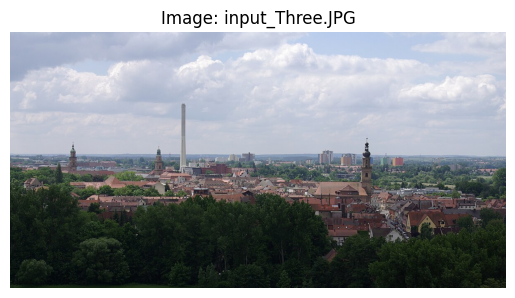

Top-1 Predicted Class ID: 978 — seashore


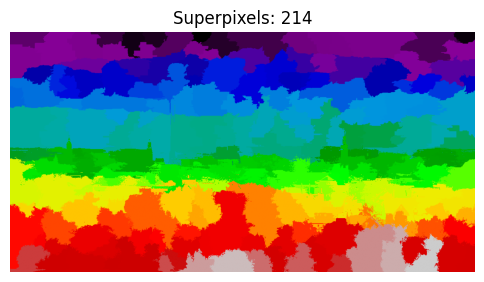

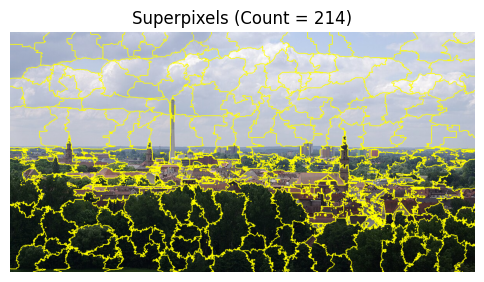


 Predicting for: input_Two.jpg


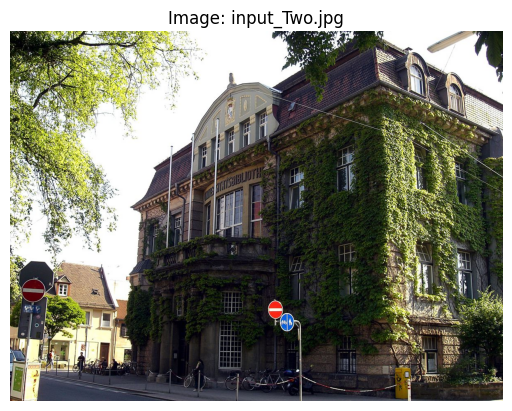

Top-1 Predicted Class ID: 698 — palace


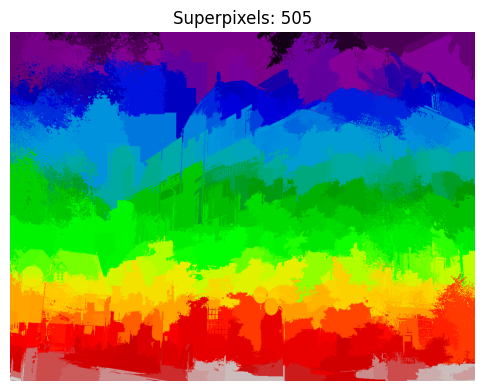

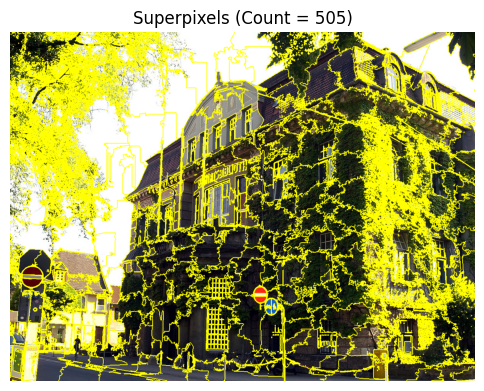


 Predicting for: input_One.JPG


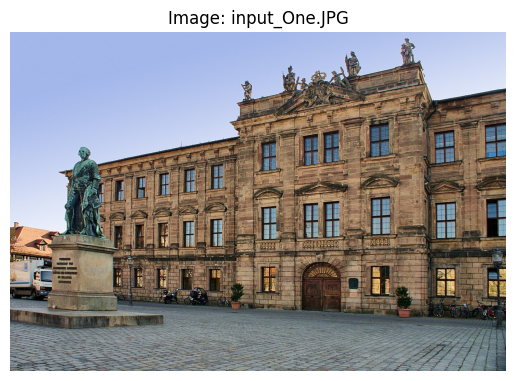

Top-1 Predicted Class ID: 698 — palace


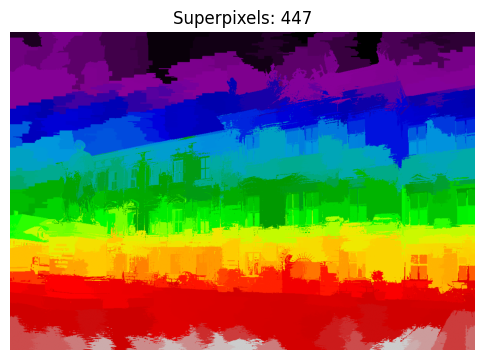

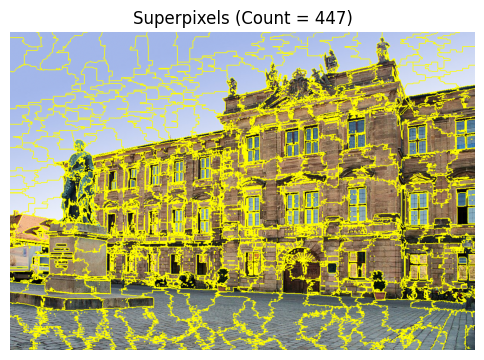

In [8]:
# Store results for all images
all_data = []

for path in paths:
    print(f"\n Predicting for: {path}")

    # Predict and get top-1 class
    img = Image.open(path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.nn.functional.softmax(output[0], dim=0)
    top_class = torch.argmax(probs).item()

    # Show image
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image: {path.split('/')[-1]}")
    plt.show()

    print(f"Top-1 Predicted Class ID: {top_class} — {labels[top_class]}")

    # Segment the image
    segments = segment_superpixels(img, ratio=2.0, kernel_size=7, max_dist=50)

    # Visualize segments
    visualize_segments_on_image(img, segments)

    # Save data for LIME steps
    all_data.append({
        "path": path,
        "image": img,
        "tensor": input_tensor,
        "top_class": top_class,
        "segments": segments
    })

## Perturbation Function

In [9]:
def perturb_image(img_np, segments, num_samples=1000, p_keep=0.5):
    """
    Generates perturbed images by turning superpixels off randomly.

    Args:
        img_np: NumPy image array (H, W, 3)
        segments: Superpixel segmentation (H, W)
        num_samples: Number of perturbed samples to generate
        p_keep: Probability of keeping a superpixel on

    Returns:
        perturbed_images: (num_samples, 3, H, W) tensor
        masks: (num_samples, num_superpixels) binary array
    """
    num_superpixels = np.unique(segments).shape[0]
    masks = np.random.binomial(1, p_keep, size=(num_samples, num_superpixels))

    # Precompute mean color of each superpixel
    avg_color = np.zeros((num_superpixels, 3))
    for i in range(num_superpixels):
        mask = segments == i
        avg_color[i] = img_np[mask].mean(axis=0)

    perturbed_imgs = []

    for i in range(num_samples):
        perturbed = img_np.copy()
        for j in range(num_superpixels):
            if masks[i, j] == 0:
                perturbed[segments == j] = avg_color[j]
        # Transform to tensor for model input
        pert_tensor = preprocess(Image.fromarray(np.uint8(perturbed))).unsqueeze(0)
        perturbed_imgs.append(pert_tensor)

    # Stack tensors
    perturbed_tensor_batch = torch.cat(perturbed_imgs, dim=0)
    return perturbed_tensor_batch, masks


 Generating perturbations for Image 1: input_Three.JPG


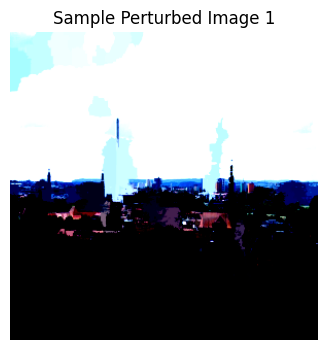


 Generating perturbations for Image 2: input_Two.jpg


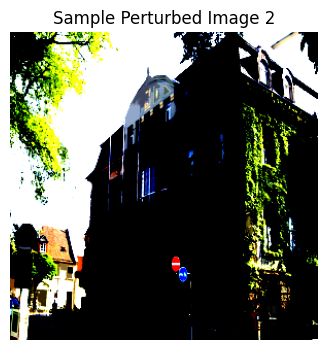


 Generating perturbations for Image 3: input_One.JPG


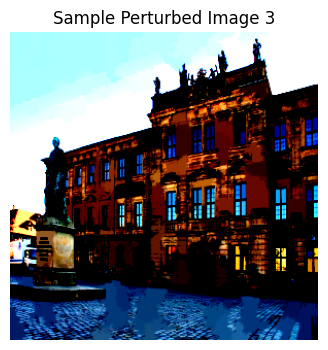

In [10]:
# Add perturbation data to each image in all_data
for i, data in enumerate(all_data):
    print(f"\n Generating perturbations for Image {i+1}: {data['path'].split('/')[-1]}")

    img_np = np.array(data['image'])
    segments = data['segments']

    perturbed_batch, masks = perturb_image(
        img_np=img_np,
        segments=segments,
        num_samples=300,
        p_keep=0.5
    )

    # Store the results
    all_data[i]['perturbed_batch'] = perturbed_batch
    all_data[i]['masks'] = masks

    # Show a sample perturbed image
    sample_tensor = perturbed_batch[0]
    sample_img = transforms.ToPILImage()(sample_tensor.cpu().clamp(0, 1))

    plt.figure(figsize=(4, 4))
    plt.imshow(sample_img)
    plt.axis('off')
    plt.title(f"Sample Perturbed Image {i+1}")
    plt.show()


## Get Predictions for Each Perturbed Image

In [11]:
def get_top_class_confidences(model, perturbed_batch, top_class):
    """
    Get the confidence for the top_class for all perturbed images.

    Args:
        model: pretrained model
        perturbed_batch: (N, 3, 299, 299) tensor
        top_class: int (original top-1 prediction to explain)

    Returns:
        confidences: (N,) numpy array
    """
    model.eval()
    with torch.no_grad():
        outputs = model(perturbed_batch)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        class_probs = probs[:, top_class]
    return class_probs.cpu().numpy()


In [12]:
for i, data in enumerate(all_data):
    print(f"\n Getting predictions for perturbed images of image {i+1}")

    perturbed_batch = data['perturbed_batch']
    top_class = data['top_class']

    confidences = get_top_class_confidences(model, perturbed_batch, top_class)
    all_data[i]['confidences'] = confidences
    print(f"Sample confidences: {confidences[:5]}")



 Getting predictions for perturbed images of image 1
Sample confidences: [0.0457786  0.02926258 0.07598409 0.00981545 0.01625521]

 Getting predictions for perturbed images of image 2
Sample confidences: [0.01900253 0.1010944  0.07074955 0.02436402 0.06142319]

 Getting predictions for perturbed images of image 3
Sample confidences: [0.38022694 0.51782775 0.323227   0.09067925 0.15112665]


## Compute Weights Using Cosine Distance

In [13]:
def compute_cosine_weights(original_tensor, perturbed_batch, kernel_width=0.25):
    """
    Compute weights for perturbed samples based on cosine distance from the original image.
    
    Args:
        original_tensor: shape (1, 3, 299, 299)
        perturbed_batch: shape (N, 3, 299, 299)
        kernel_width: float (bandwidth for the exponential kernel)

    Returns:
        weights: shape (N,) numpy array
    """
    N = perturbed_batch.shape[0]
    
    # Flatten the images to (N, D)
    original_flat = original_tensor.view(1, -1).cpu().numpy()
    perturbed_flat = perturbed_batch.view(N, -1).cpu().numpy()

    # Compute cosine distances
    distances = pairwise_distances(original_flat, perturbed_flat, metric='cosine')[0]

    # Kernel function: exp(-distance^2 / kernel_width^2)
    weights = np.exp(-(distances ** 2) / (kernel_width ** 2))

    return weights


In [16]:
for i, data in enumerate(all_data):
    print(f"\n Computing weights for image {i+1}")

    original_tensor = data['tensor']
    perturbed_batch = data['perturbed_batch']

    weights = compute_cosine_weights(original_tensor, perturbed_batch)
    all_data[i]['weights'] = weights

    print(f"Sample weights: {weights[:5]}")



 Computing weights for image 1
Sample weights: [0.99939907 0.9994984  0.99930465 0.9992241  0.9992745 ]

 Computing weights for image 2
Sample weights: [0.997289   0.9985789  0.9976909  0.9987691  0.99822056]

 Computing weights for image 3
Sample weights: [0.9972827  0.9965173  0.99597245 0.9952211  0.9948197 ]


## Fit the Surrogate Model

In [19]:
for i, data in enumerate(all_data):
    print(f"\n Fitting surrogate model for image {i+1}")

    X = data['masks']                     # shape: (num_samples, num_superpixels)
    y = data['confidences']              # shape: (num_samples,)
    weights = data['weights']            # shape: (num_samples,)

    # Fit weighted linear regression
    model = LinearRegression()
    model.fit(X, y, sample_weight=weights)

    # Save coefficients (importance per superpixel)
    data['coefficients'] = model.coef_
    print(f"Top 5 important superpixels (abs coef): {np.argsort(np.abs(model.coef_))[::-1][:5]}")


 Fitting surrogate model for image 1
Top 5 important superpixels (abs coef): [ 75  87  59 186 211]

 Fitting surrogate model for image 2
Top 5 important superpixels (abs coef): [207 290 447 143  57]

 Fitting surrogate model for image 3
Top 5 important superpixels (abs coef): [287 324 219 345 108]


## LIME Explanation Visualization

In [20]:
def visualize_lime_explanation(image, segments, coefficients, top_k=10):
    """
    Visualize top-K important superpixels based on LIME explanation.
    
    Args:
        image: PIL image
        segments: 2D array of superpixel labels
        coefficients: importance scores for each superpixel
        top_k: number of top contributing superpixels to highlight
    """
    img_np = np.array(image)

    # Get indices of top-K absolute coefficient values
    top_superpixels = np.argsort(np.abs(coefficients))[::-1][:top_k]

    # Create a mask highlighting top superpixels
    mask = np.zeros(segments.shape, dtype=bool)
    for idx in top_superpixels:
        mask |= (segments == idx)

    # Overlay boundaries
    highlighted = mark_boundaries(img_np, segments, color=(1, 0, 0))  # red borders
    highlighted[~mask] = img_np[~mask]  # dim rest if you want (optional)

    plt.figure(figsize=(6, 6))
    plt.imshow(highlighted)
    plt.title(f"Top {top_k} Superpixels (LIME Explanation)")
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



🖼️ LIME Visualization for Image 1


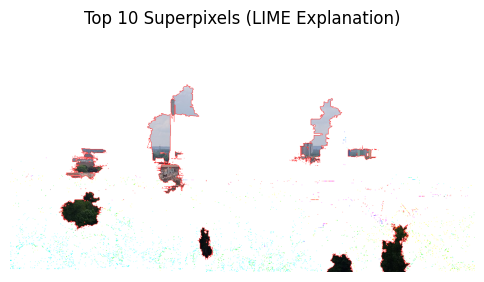

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].



🖼️ LIME Visualization for Image 2


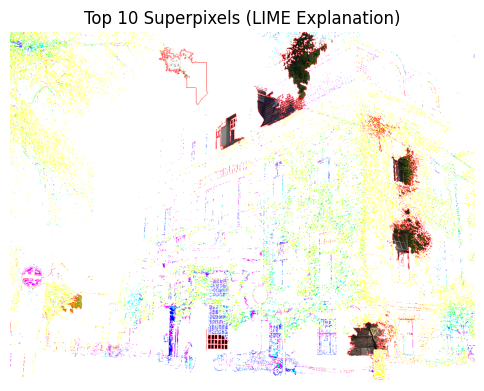


🖼️ LIME Visualization for Image 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


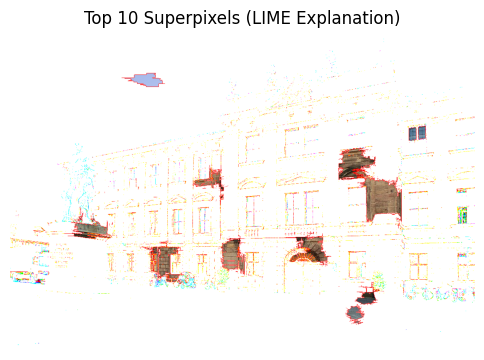

In [21]:
for i, data in enumerate(all_data):
    print(f"\n🖼️ LIME Visualization for Image {i+1}")
    visualize_lime_explanation(
        image=data['image'],
        segments=data['segments'],
        coefficients=data['coefficients'],
        top_k=10
    )


## 2. Test SHAP

For the same images, you should now use the SHAP algorithm to provide visual explanations. In this case, you do not need to implement the algorithm. Instead, you could use an existing Python library such as [SHAP](https://shap.readthedocs.io/en/latest/image_examples.html). ResNet 50 is a good reference for running the tests. Inception V3 can also be used. For this task, [TensorFlow](https://www.tensorflow.org) can be used as well.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

![](https://shap.readthedocs.io/en/latest/_images/example_notebooks_image_examples_image_classification_Explain_ResNet50_using_the_Partition_explainer_10_0.png)

In [25]:

import shap
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

## Load Pretrained ResNet50

In [26]:
model = models.resnet50(weights="IMAGENET1K_V2")   # PyTorch ≥ 2.0
model.eval()                                        # leave on CPU

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/user/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:22<00:00, 4.51MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])


## Wrap model for SHAP

In [35]:
# ----------------------- 3. SHAP explainer ------------------
# a single black image is enough for baseline; keep it on CPU
background = torch.zeros((1, 3, 224, 224))
explainer  = shap.DeepExplainer(model, background)   # much faster than GradientExplainer

# ----------------------- 4. helper --------------------------
def explain_image(img_path: str, idx: int):
    print(f"\nProcessing image {idx}:  {img_path}")
    img = Image.open(img_path).convert("RGB")

    # --- display original ---
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Original {idx}")
    plt.show()

    # --- forward pass + SHAP ---
    x = preprocess(img).unsqueeze(0)        # shape: (1,3,224,224)
    with torch.no_grad():
        preds = torch.nn.functional.softmax(model(x), dim=1)

    shap_values = explainer.shap_values(
        x,
        ranked_outputs=1,   # only the top‑predicted class
        nsamples=200        # good speed/quality trade‑off on CPU
    )

    # --- undo normalisation for nice colours ---
    x_np = x[0].permute(1,2,0).numpy()
    x_np = np.clip(x_np * [0.229,0.224,0.225] + [0.485,0.456,0.406], 0, 1)

    shap.image_plot([shap_values], [x_np])


Processing image 1:  input_One.JPG


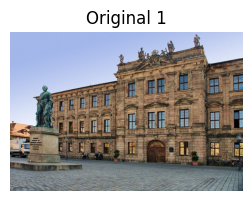

TypeError: DeepExplainer.shap_values() got an unexpected keyword argument 'nsamples'

In [36]:
paths = ["input_One.JPG", "input_Two.jpg", "input_Three.JPG"]
for i, p in enumerate(paths, 1):
    explain_image(p, i)